In [1]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.observationsAndERA5.mountainUtils import *

from scipy.stats import linregress
xr.set_options(display_style='text') 

# Functions, data loading

In [2]:
# Monthly data
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81

gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-202012.nc")

era5100u_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2020.nc")
era5100v_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2020.nc")

topo_hires = xr.open_dataset("/global/cscratch1/sd/qnicolas/ETOPO1_Ice_g_gmt4.grd").z.rename({'x':'longitude','y':'latitude'})
topo_hires = topo_hires.reindex(latitude=list(reversed(topo_hires.latitude)))
topo_hires.coords['longitude'] = topo_hires.coords['longitude'] % 360
topo_hires = topo_hires.sortby(topo_hires.longitude)

monthnames=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


In [3]:
Ghats      = MountainRangeCustom("ghats"      ,[64,82,7,24]   ,"Western Ghats"           ,70 ,[6,7,8]  ,[ 75  ,   9  ,  71.5, 20   ,2  ])
Myanmar    = MountainRangeCustom("myanmar"    ,[84,102,7,24]  ,"Myanmar"                 ,60 ,[6,7,8]  ,[ 98  ,  11  ,  90  , 21   ,4  ])
Vietnam    = MountainRangeCustom("vietnam"    ,[100,118,8,25] ,"Annamite range (Vietnam)",240,[10,11]  ,[108  ,  18  , 111  , 13   ,2  ])
Malaysia   = MountainRangeCustom("malaysia"   ,[96,114,-2,15] ,"Malaysia"                ,225,[11,12]  ,[102.5,   8  , 105.5,  3   ,2  ])
Philippines= MountainRangeCustom("philippines",[117,135,5,22] ,"Philippines"             ,225,[11,12]  ,[123.5,  17  , 127  ,  9   ,2  ])
Newbritain = MountainRangeCustom("newbritain" ,[145,163,-17,0],"New Britain"             ,320,[6,7,8]  ,[154  , - 5.5, 150  , -8.5 ,2  ])

MRs = (Ghats,Myanmar,Vietnam,Malaysia,Philippines,Newbritain)


for MR in MRs:
    print(MR.name)
    MR.set_2dvar('GPM_PR',gpm_pr_seasmean)
    MR.set_2dvar('VAR_100U',era5100u_seasmean)
    MR.set_2dvar('VAR_100V',era5100v_seasmean)
    MR.set_2dvar('Z',orogm)
    MR.set_2dvar('Z_HR',np.maximum(topo_hires,0.))
    MR.set_3dvar('T',"128_130_t")
    MR.set_3dvar('Q',"128_133_q")
    MR.set_3dvar('U',"128_131_u")
    MR.set_3dvar('V',"128_132_v")
    MR.set_uperp()
    

ghats
myanmar
vietnam
malaysia
philippines
newbritain


In [4]:
for MR in MRs:
    filepath = MR.path+"e5.diagnostic.thetaeLsemi.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name) 
    thetaeL = xr.open_dataarray(filepath)
    MR.vars['THETAELSEMI_DAILY'] = thetaeL

In [6]:
for MR in MRs:
    print(MR.name)
    MR.set_daily_spavg_var('162_071_viwve','VIWVE','vinteg',where='upstream')
    MR.set_daily_spavg_var('162_072_viwvn','VIWVN','vinteg',where='upstream')
    MR.set_viwvperp_sfc()
    MR.set_daily_imerg()
    MR.set_daily_sfc_var('128_034_sstk','SST')
    MR.vars['UBL_DAILY'] = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.diagnostic.uBL.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    MR.vars['VBL_DAILY'] = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.diagnostic.vBL.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    MR.set_daily_Bl_vars('semi')
    
    for varname in 'SST','THETAEBSEMI','THETAELSEMI','TLSEMI','QLSEMI','BLSEMI','GPM_PR':
        grid = MR.vars[varname+'_DAILY']
        MR.set_spatialmean(varname,'above',tilted_rect(grid,*MR.box_tilted,reverse=False),box=None)


ghats
myanmar
vietnam
malaysia
philippines
newbritain


In [8]:
from scipy.optimize import curve_fit
def fit(pred,dep,model='linear'):
    predrange = np.linspace(np.min(pred),np.max(pred),41)
    if model=='linear':
        func = lambda x,a,b : a*x+b
    elif model=='exponential':
        func = lambda x,a,b : np.exp(a*x+b)
    elif model=='softplus':
        func = lambda x,a,b : np.log(1+np.exp(a*x+b))
    popt,_ = curve_fit(func,pred,dep)
    fitrange = func(predrange,*popt)
    residual = dep - func(pred,*popt)
    rss = np.sum(residual**2)
    tss = len(dep)*np.var(dep)
    rsq = 1-rss/tss
    return predrange,fitrange,rsq

def get_bins(var,nbins):
    var_sorted = sorted(np.array(var).reshape(-1))
    quantiles=np.linspace(0.,len(var)-1,nbins+1)
    bins = [var_sorted[int(i)]  for i in quantiles]
    bin_centers = [np.mean(var_sorted[int(quantiles[i]):int(quantiles[i+1])]) for i in range(len(quantiles)-1)]
    return np.array(bins)#,np.array(bin_centers)

def select_bootstrap_sample(distribution):
    n=len(distribution)
    return distribution[np.random.randint(0,n,size=n)]
def bootstrap_CI_mean(data,CI_level,nsamples=10):
    """Compute a confidence interval for the mean of a et of data at the level CI_level (0<CI_level<100), using nsamples bootstrap samples"""
    means = np.array([select_bootstrap_sample(data).mean() for _ in range(nsamples)])
    return [np.percentile(means,50-CI_level/2),np.percentile(means,50+CI_level/2)]

def get_binned(a,b,bins,itq=False,bootstrap=False):
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    if itq:
        bin_median = np.array([np.median(np.array(b)[digitized == i]) for i in range(1, len(bins))])
        try:
            bin_q1 = np.array([np.quantile(np.array(b)[digitized == i],0.25) for i in range(1, len(bins))])
            bin_q2 = np.array([np.quantile(np.array(b)[digitized == i],0.75) for i in range(1, len(bins))])
        except IndexError:
            bin_q1 = bin_median
            bin_q2 = bin_median
        return bin_centers,bin_means,bin_median,bin_q1,bin_q2
    elif bootstrap :
        cinf_csup =  np.array([bootstrap_CI_mean(np.array(b)[digitized == i],95) for i in range(1, len(bins))])
        return bin_centers,bin_means,cinf_csup[:,0],cinf_csup[:,1]
    else:
        return bin_centers,bin_means
    
def get_count(a,bins):
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    count = np.histogram(a,bins)[0]
    return bin_centers,count

# SST

In [34]:
for i,MR in enumerate(MRs):
    pred = MR.vars['THETAEBSEMI_ABOVE_DAILY']
    var = MR.vars['SST_ABOVE_DAILY']
    print(MR.name+' %.1f%%'%(100*np.corrcoef(pred,var)[0,1]))

ghats 80.3%
myanmar 53.4%
vietnam 61.0%
malaysia 69.4%
philippines 52.0%
newbritain 59.9%


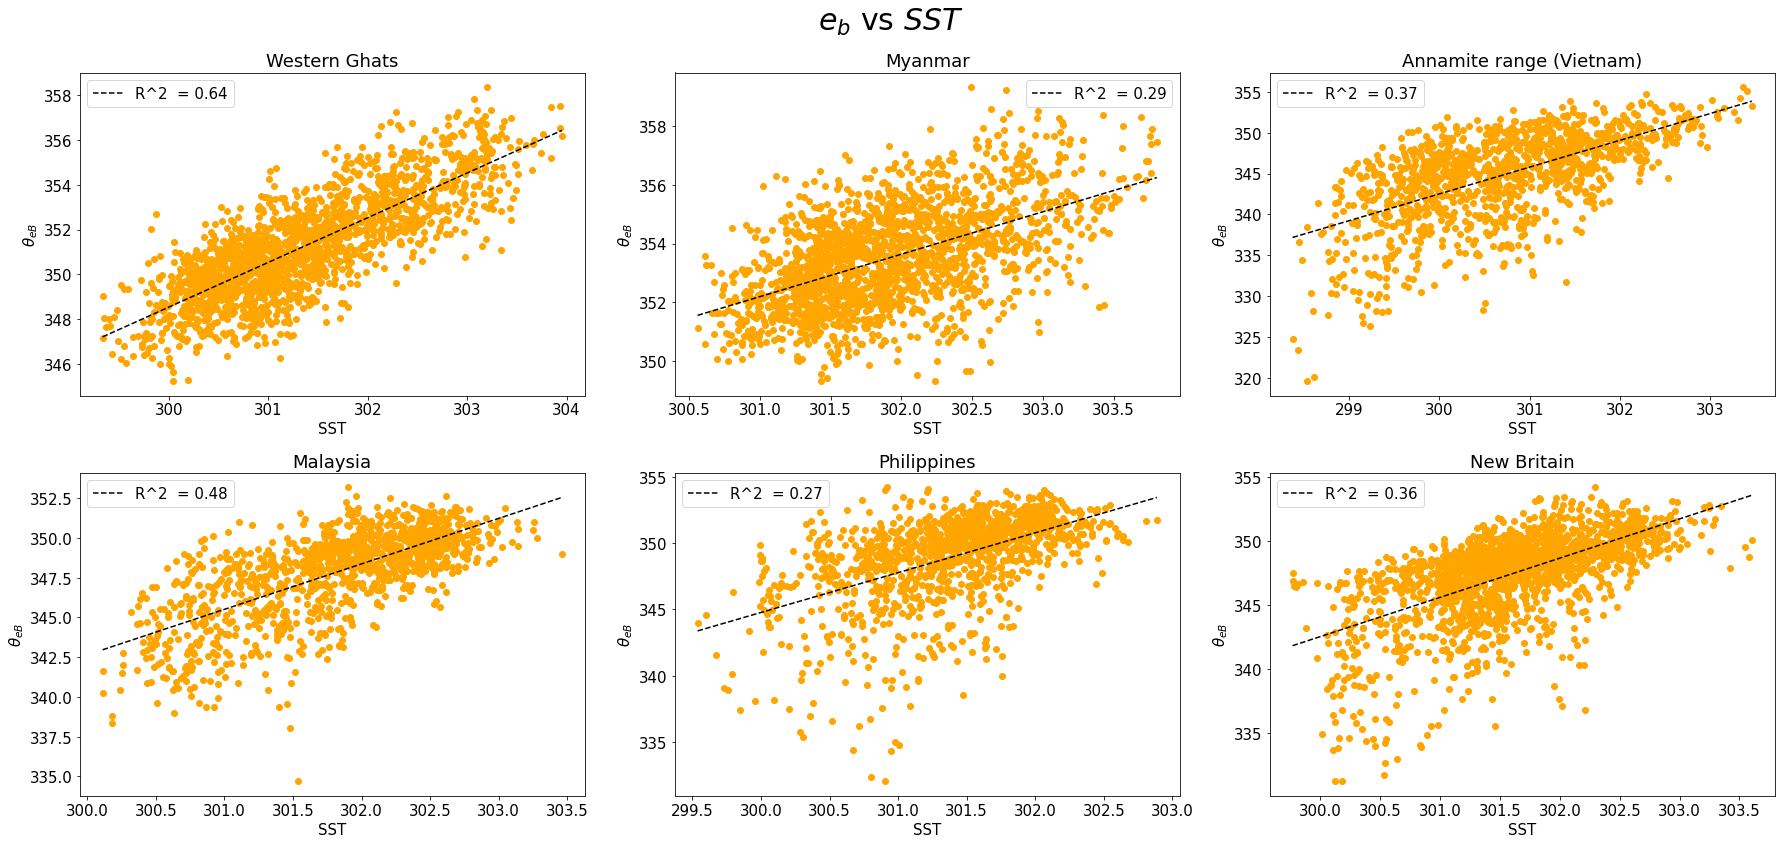

In [9]:
fig,axs = plt.subplots(2,3,figsize=(25,12))
axs=axs.reshape(-1)
for i,MR in enumerate(MRs):
    pred = MR.vars['THETAEBSEMI_ABOVE_DAILY']
    var = MR.vars['SST_ABOVE_DAILY']

    axs[i].scatter(var,pred,color='orange')
    x,y,rsq = fit(np.array(var),np.array(pred),'linear')
    axs[i].plot(x,y,color='k',linestyle='--',label='R^2  = %.2f'%rsq)
    axs[i].set_title(MR.Lname)
    axs[i].legend()
    #print('{:<11s} : {:>2d} % variance explained'.format(MR.name,int(100*popt[0]**2*var.var('time')/pred.var('time'))))
    #axs[i].set_xlim(298,304.5)
    #axs[i].set_ylim(320,360)
    axs[i].set_xlabel("SST")
    axs[i].set_ylabel(r"$\theta_{eB}$")
fig.suptitle(r"$e_{b}$ vs $SST$",fontsize=30)
fig.tight_layout()

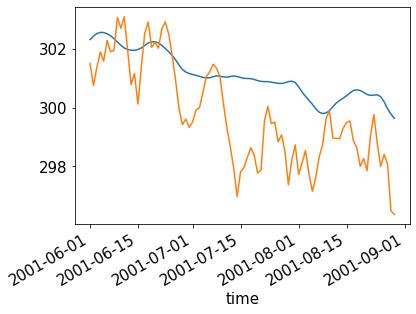

In [11]:
Ghats.vars['SST_ABOVE_DAILY'][:90].plot()

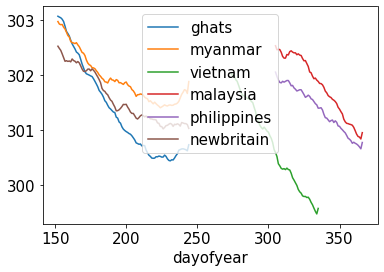

In [18]:
for MR in MRs:
    MR.vars['SST_ABOVE_DAILY'].groupby('time.dayofyear').mean().plot(label=MR.name)
plt.legend()

# $\theta_{eL}$ 

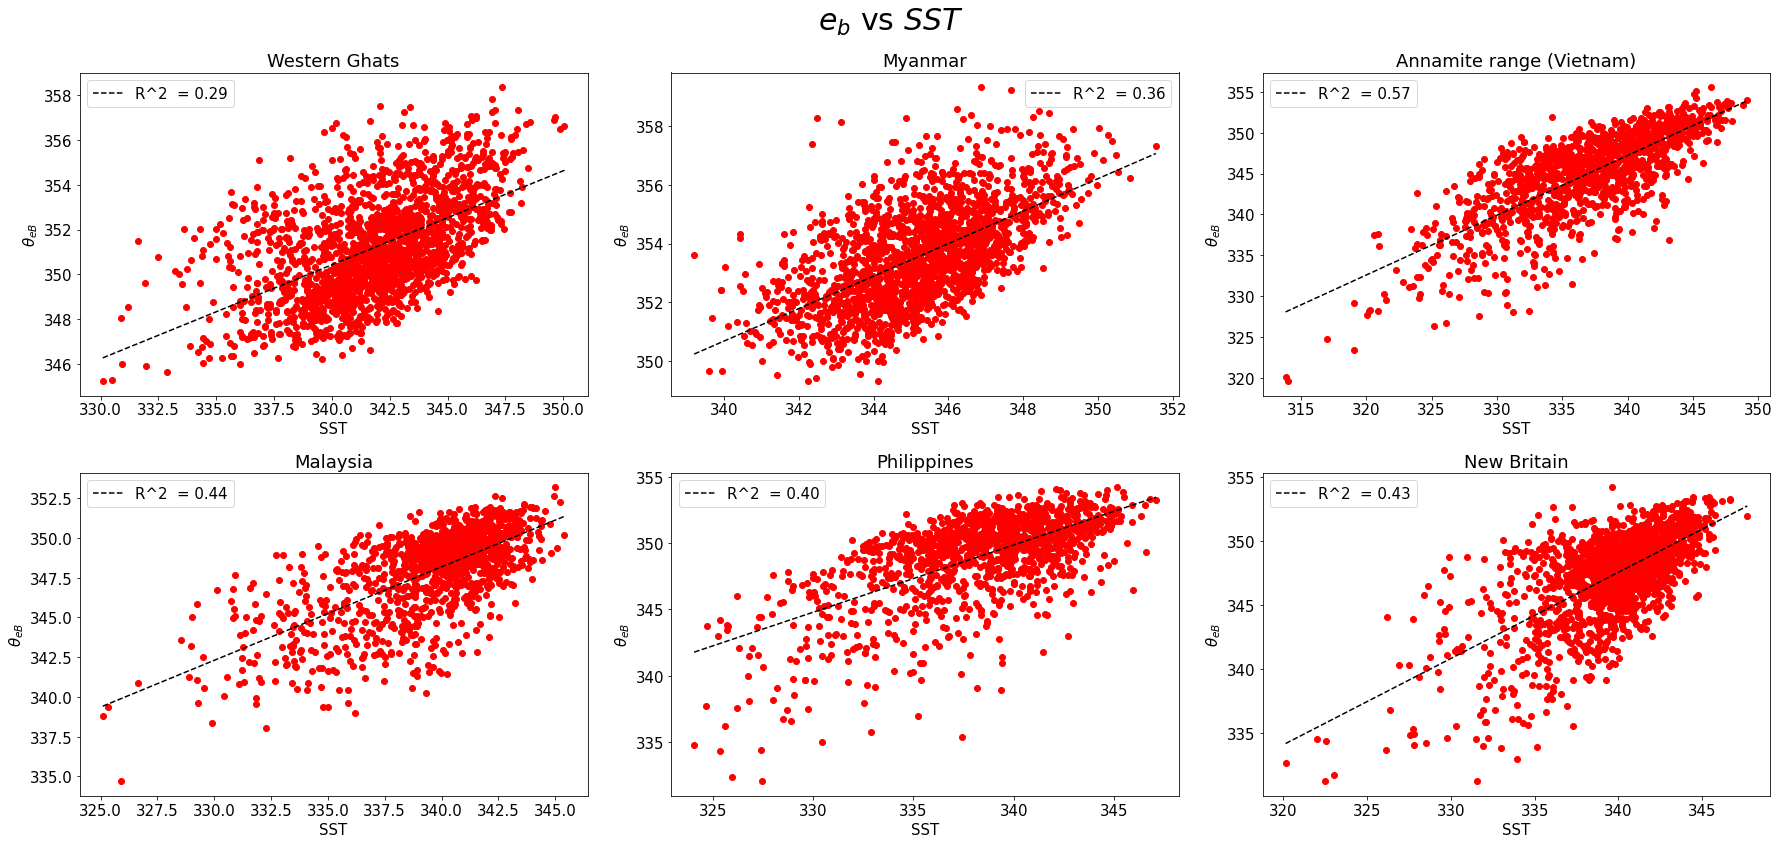

In [19]:
fig,axs = plt.subplots(2,3,figsize=(25,12))
axs=axs.reshape(-1)
for i,MR in enumerate(MRs):
    pred = MR.vars['THETAEBSEMI_ABOVE_DAILY']
    var = MR.vars['THETAELSEMI_ABOVE_DAILY']

    axs[i].scatter(var,pred,color='r')
    x,y,rsq = fit(np.array(var),np.array(pred),'linear')
    axs[i].plot(x,y,color='k',linestyle='--',label='R^2  = %.2f'%rsq)
    axs[i].set_title(MR.Lname)
    axs[i].legend()
    #print('{:<11s} : {:>2d} % variance explained'.format(MR.name,int(100*popt[0]**2*var.var('time')/pred.var('time'))))
    #axs[i].set_xlim(298,304.5)
    #axs[i].set_ylim(320,360)
    axs[i].set_xlabel("SST")
    axs[i].set_ylabel(r"$\theta_{eB}$")
fig.suptitle(r"$e_{b}$ vs $SST$",fontsize=30)
fig.tight_layout()

# precip

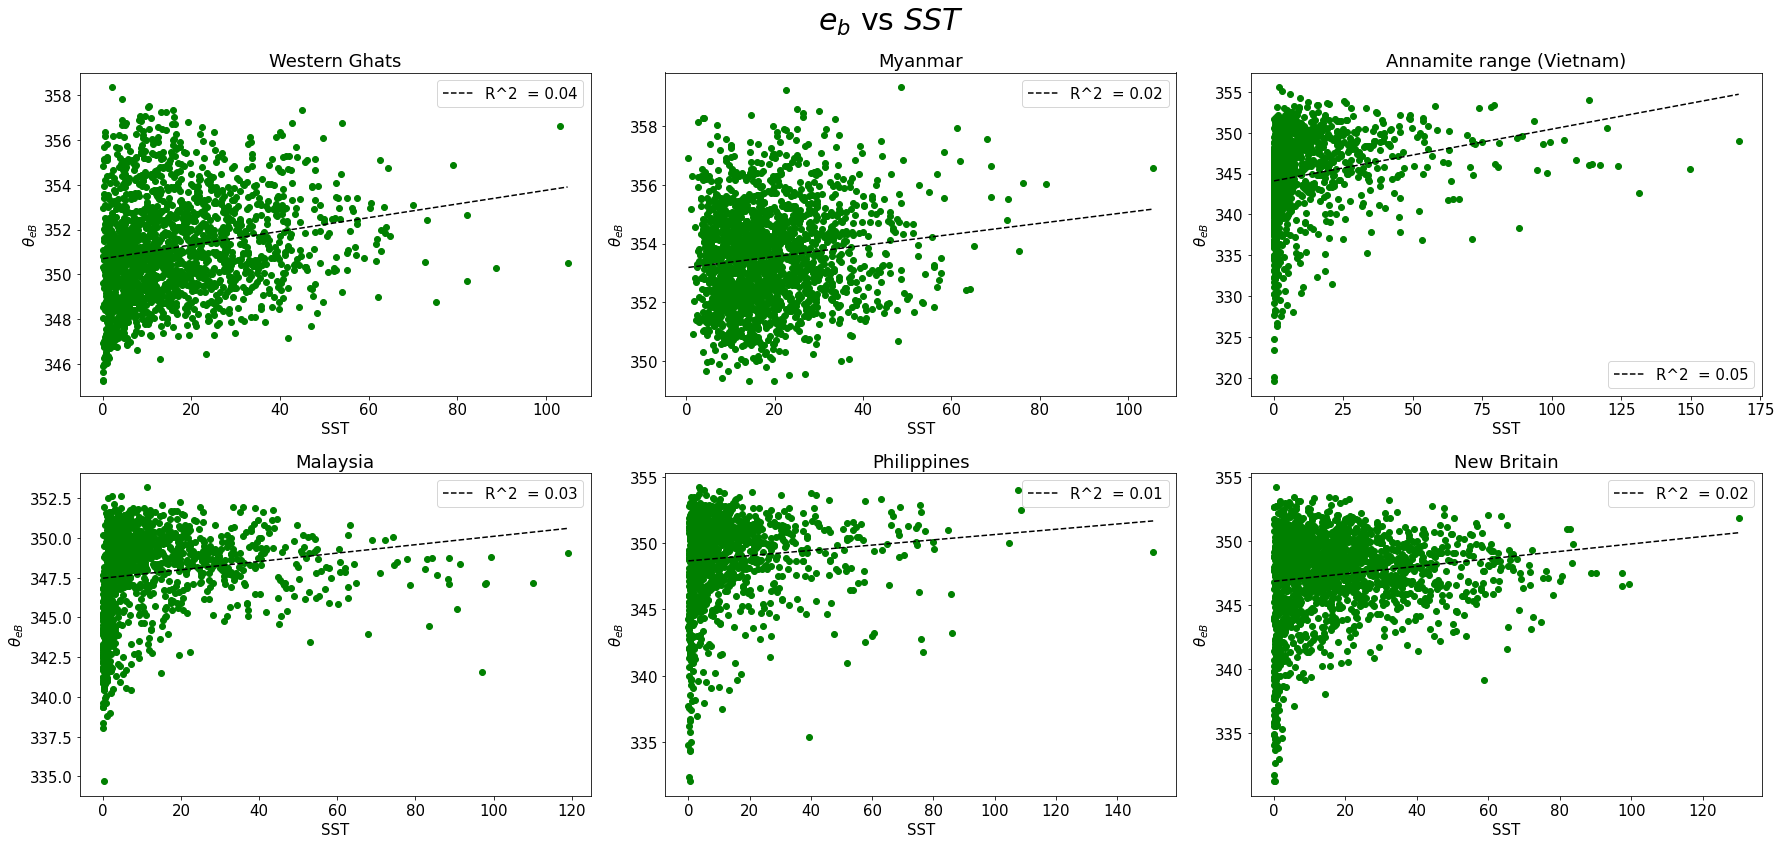

In [20]:
fig,axs = plt.subplots(2,3,figsize=(25,12))
axs=axs.reshape(-1)
for i,MR in enumerate(MRs):
    pred = MR.vars['THETAEBSEMI_ABOVE_DAILY']
    var = MR.vars['GPM_PR_ABOVE_DAILY']

    axs[i].scatter(var,pred,color='g')
    x,y,rsq = fit(np.array(var),np.array(pred),'linear')
    axs[i].plot(x,y,color='k',linestyle='--',label='R^2  = %.2f'%rsq)
    axs[i].set_title(MR.Lname)
    axs[i].legend()
    #print('{:<11s} : {:>2d} % variance explained'.format(MR.name,int(100*popt[0]**2*var.var('time')/pred.var('time'))))
    #axs[i].set_xlim(298,304.5)
    #axs[i].set_ylim(320,360)
    axs[i].set_xlabel("SST")
    axs[i].set_ylabel(r"$\theta_{eB}$")
fig.suptitle(r"$e_{b}$ vs $SST$",fontsize=30)
fig.tight_layout()

# Winds

In [21]:
from scipy import special
def linregress_xr_2(x,y,dim='time'):
    nt = len(x[dim])
    assert nt==len(y[dim])
    ssxm = nt*x.var(dim=dim)
    ssym = nt*y.var(dim=dim)
    ssxym = nt*xr.cov(x,y,dim=dim)       
    r = np.maximum(np.minimum(ssxym / np.sqrt(ssxm * ssym),1.),-1)
    slope = ssxym / ssxm
    
    df = nt - 2  # Number of degrees of freedom
    TINY = 1.0e-20
    t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
    
    pval = special.stdtr(df, -np.abs(t))*2 * x.isel({dim:0})**0
    
    return xr.merge([slope.rename('slope'),(r**2).rename('rsquared'),pval.rename('pvalue')])

def fdr(pvalues,alpha):
    sortidx = np.argsort(pvalues)
    psorted = pvalues[sortidx]
    psorted[np.isnan(psorted)]=1
    nval = len(pvalues)
    ifdr = np.argmax((psorted < alpha*np.arange(1,nval+1)/nval)[::-1])
    if ifdr == 0 and psorted[-1]>= alpha:
        ifdr=nval-1
    ifdr = nval - ifdr - 1
    return sortidx[:ifdr]

def fdr_xr_2d(pvalues,alpha):
    pvalues=np.array(pvalues)
    assert len(pvalues.shape)==2
    ntot = pvalues.shape[0]*pvalues.shape[1]
    idxs_1d = fdr(pvalues.reshape(-1),alpha)
    flags = np.zeros(ntot)
    flags[idxs_1d] = 1
    return flags.reshape(pvalues.shape)*pvalues**0

In [22]:
def add_wind(ax,u,v,color='k',width=0.001,scale=600,key=True,ref=100,app='/(m/s2)',pos=(0.87,1.03)):
    ax.coastlines()
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = v.longitude.expand_dims({"latitude":u.latitude})
    n=5
    m=5
    q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color=color,width=width,scale=scale)
    if key:
        ax.quiverkey(q, *pos, ref, label='', labelpos='E', coordinates='axes',color='k',angle=90)
        
def add_latlon(ax,box):
    ax.set_anchor('W')
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    ax.set_xticks(lons)
    ax.set_xticklabels(lons)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    ax.set_yticks(lats)
    ax.set_yticklabels(lats)
    ax.set_xlabel("")
    ax.set_ylabel("")
        

Text(0.5, 0.98, 'Winds regressed onto T_L')

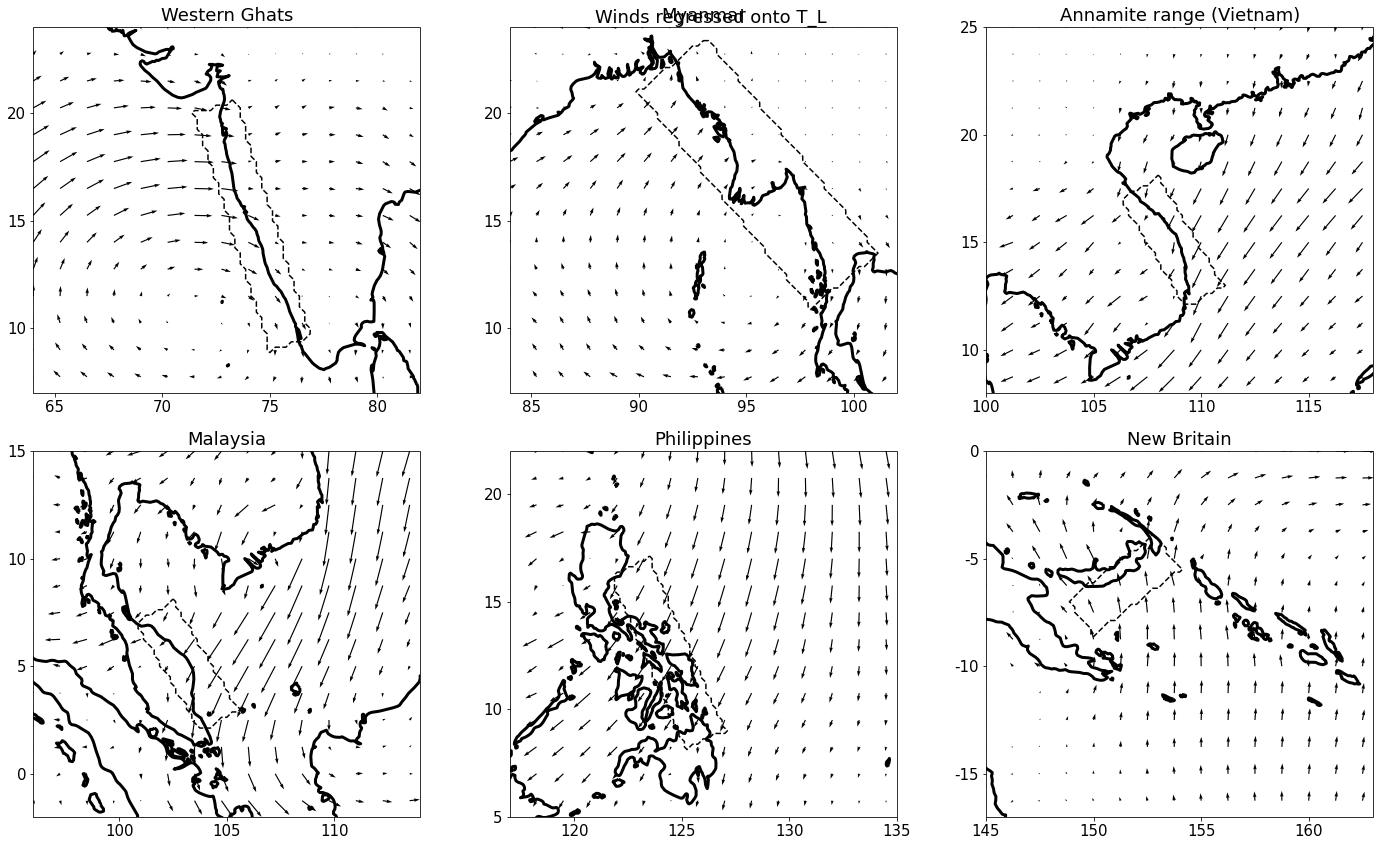

In [27]:
fig,axs = plt.subplots(2,3,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
predname = 'TL_DAILY'

levs = np.linspace(-60,60,21)
varname = 'UBL_DAILY'

for i,(ax,MR) in enumerate(zip(axs,MRs)):
    pred = -MR.vars['TLSEMI_ABOVE_DAILY']
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    add_wind(ax,u,v,width=0.003,scale=70,key=False)

    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)

fig.tight_layout()
plt.suptitle('Winds regressed onto T_L')

Text(0.5, 0.98, 'Winds regressed onto thetaeB')

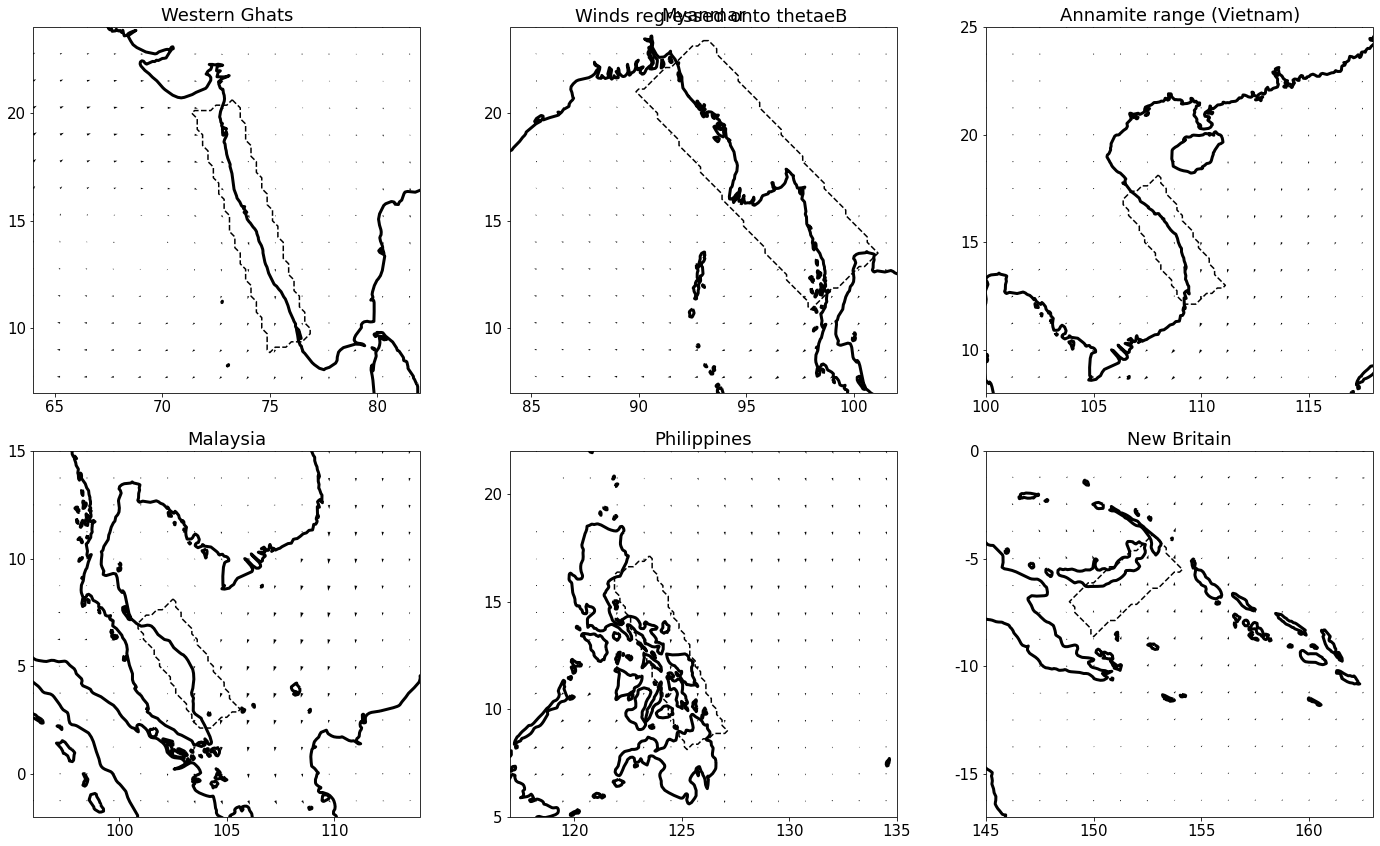

In [28]:
fig,axs = plt.subplots(2,3,figsize=(20,12),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
predname = 'TL_DAILY'

levs = np.linspace(-60,60,21)
varname = 'UBL_DAILY'

for i,(ax,MR) in enumerate(zip(axs,MRs)):
    pred = -MR.vars['THETAEBSEMI_ABOVE_DAILY']
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    add_wind(ax,u,v,width=0.003,scale=70,key=False)

    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)

fig.tight_layout()
plt.suptitle('Winds regressed onto thetaeB')

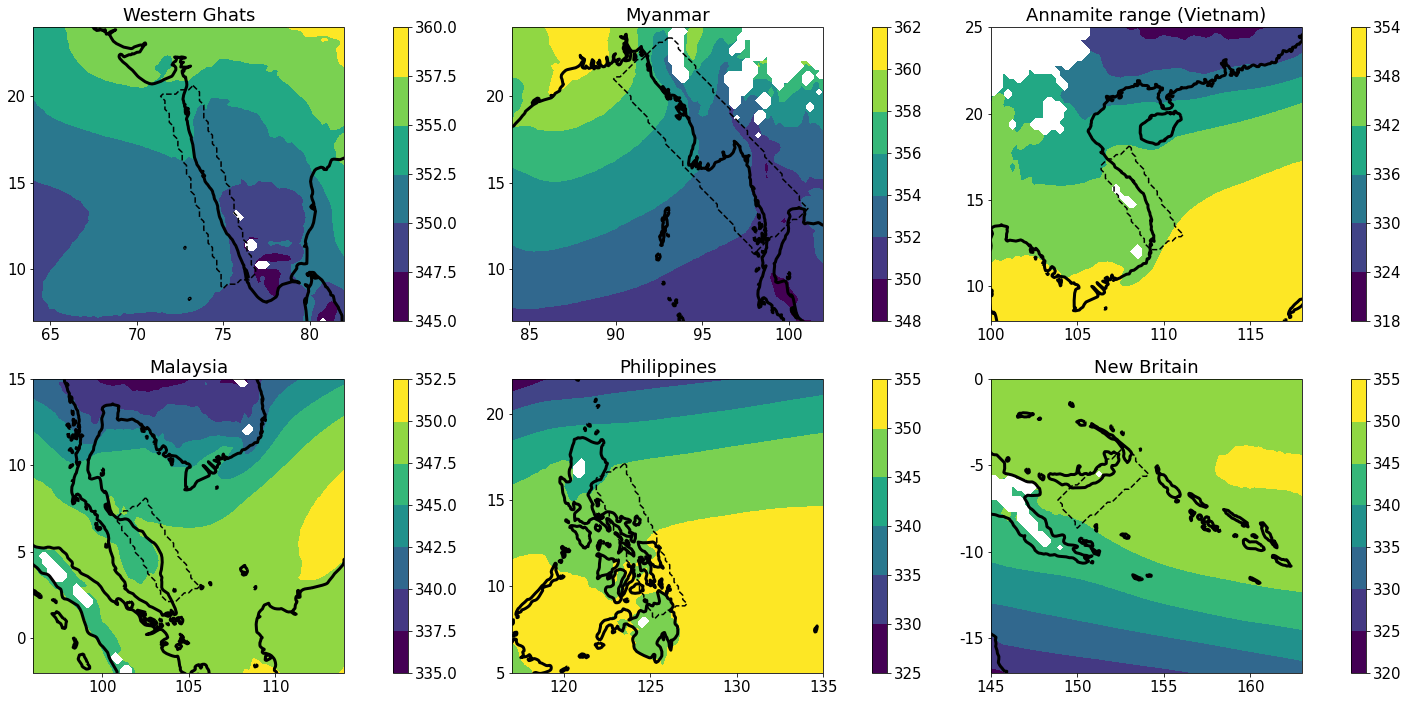

In [31]:
fig,axs = plt.subplots(2,3,figsize=(20,10),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
for (ax,MR) in zip(axs,MRs):
    plot = MR.vars['THETAEBSEMI_DAILY'].mean('time')
    plot.plot.contourf(ax=ax,transform = ccrs.PlateCarree())
    
    tilted_rect(plot,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box)
fig.tight_layout()